In [ ]:
from utils_parallel import exponential_backoff, process_in_parallel

from pathlib import Path
import numpy as np
import pandas as pd
from datasets import load_dataset

/workspace/ALGOVERSE/yas/yulia/parascopes/.yulia-venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
DECODED_CSV = "/workspace/ALGOVERSE/yas/yulia/parascopes/src/yulia/outlines/decoded_outputs_chunk_999.csv"

# Hugging Face parquet with the last 100k completions (we only take last 1000)
HF_PQ = "yulia-volkova/parascopes-outlines-data@main/v5.0/data/outlines_009.parquet"

# Output files
OUT_DIR = Path("./eval_outlines"); OUT_DIR.mkdir(exist_ok=True, parents=True)
OUT_JSONL_PRED = OUT_DIR / "rubric_predicted.jsonl"
OUT_JSONL_ORIG = OUT_DIR / "rubric_original.jsonl"
OUT_SUMMARY_CSV = OUT_DIR / "rubric_summary.csv"

In [6]:
REF_COL = "outline_generated"  

# --- Load parquet from HF and take last 1000 ---
ds = load_dataset("parquet", data_files=f"hf://datasets/{HF_PQ}")["train"]
n = len(ds)
tail = ds.select(range(n-1000, n))  # last 1000

ref_df = tail.to_pandas().reset_index(drop=True)
ref_df["index"] = np.arange(1000)  # local 0..999 index within chunk 999

if REF_COL not in ref_df.columns:
    raise RuntimeError(f"Column '{REF_COL}' not found in parquet. Available: {ref_df.columns.tolist()}")

dec_df = pd.read_csv(DECODED_CSV)
# keep only chunk 999 and needed columns
need_cols = {"chunk","index","decoded_original","decoded_predicted"}
missing = need_cols - set(dec_df.columns)
if missing:
    raise RuntimeError(f"Decoded CSV missing columns: {missing}")

dec_df = dec_df[dec_df["chunk"] == 999].copy()
dec_df = dec_df.sort_values("index").reset_index(drop=True)

# --- Merge on 'index' so rows align: original (ref_df[REF_COL]) vs decoded_* ---
merged = ref_df.merge(dec_df[["index","decoded_original","decoded_predicted"]], on="index", how="inner")

print("Merged shape:", merged.shape)
merged.head(3)

Merged shape: (1000, 10)


,example_id,dataset_idx,model,completion,outline_generated,reconstructed_text,embedding_id,index,decoded_original,decoded_predicted
0,999000,999000,meta-llama/Llama-3.3-70B-Instruct,**The Sugar Maple: From Forest to Farm**\n\nTh...,Outline:\n1. Sugar Maple Characteristics\n -...,,999000,0,Summary: 1.Sugar maple leaves - valuable chara...,Summary: 1. Design of Sugarcane Branch - 2. Li...
1,999001,999001,meta-llama/Llama-3.3-70B-Instruct,A Legacy of Union: The United Church of Christ...,Outline:\n1. United Church of Christ history\n...,,999001,1,Description: 1. History of the United Christ C...,Summary: 1. Origin - Church of England 2. Foun...
2,999002,999002,meta-llama/Llama-3.3-70B-Instruct,**Discontinuity Proofs with Epsilon-Delta**\n\...,Outline:\n1. Epsilon-Delta Definition\n - Di...,,999002,2,Summary: 1.Epsilon-Delta Definition - Disconti...,Summary: 1. Explanation of deferential consona...


In [8]:
rubric = """
#### 0. Complexity
How complex is the outline text?
0: Trivial (e.g: just says "** Section **")
1. Simple (e.g: "** Section 1: Green Tea **")
2. Some detail (e.g: a short undetailed sentence or two about something)
3. Many details (e.g: a detailed paragraph with specific information)

#### 1. Coherence (Outline-Level)
Does Outline 2 make sense as an outline compared to Outline 1?
0: Completely incoherent (e.g., excessive repetition, nonsensical phrases, strange symbols).
1: Partially coherent, but repetitive or has formatting issues (e.g., repeated key phrases, awkward pauses).
2: Mostly coherent with minor grouping/order issues.
3: Clear, logical, coherent outline structure.

#### 2. Hierarchy / Structure
How well does Outline 2 preserve the hierarchical levels (headings vs sub-bullets)?
0: No recognizable hierarchy; flat or malformed.
1: Basic levels exist but often mis-nested.
2: Mostly correct hierarchy with some mismatches.
3: Hierarchy closely matches with minimal deviations, highly similar structure.

#### 3. Coverage of Key Sections
Do the major sections in Outline 1 appear in Outline 2?
0: Most key sections missing or unrelated.
1: About half of major sections appear.
2: Most sections present; minor omissions.
3: All major sections present (allow synonyms/regrouping).

#### 4. Ordering / Flow
Does the order of major sections and sub-sections follow Outline 1?
0: Largely shuffled or illogical.
1: Partial overlap but frequent swaps.
2: Mostly consistent with minor swaps.
3: Order closely matches.

#### 5. Subject Match
How similar is the subject of Outline 2 to Outline 1?
-1: No subjects to compare.
0: Completely unrelated subjects ("corporate law" vs "particle physics")
1: Vaguely similar field (e.g: "biology" vs "physics" are both sciences)
2: Related general domain or adjacent fields (e.g., "history" vs. "archaeology" or "alternative medicine" vs. "traditional remedies").
3: Same subject (e.g., both discuss "ancient mayans" or "the properties of the human body").
4: Identical focus (e.g., both analyze "ancient mayan architecture").

#### 6. Entities / Key Concepts
How well does Outline 2 preserve entities or technical terms from Outline 1?
-1: No entities to compare.
0: Unrelated entities.
1: Same category but little overlap.
2: Some overlap or synonyms.
3: Most entities/terms preserved.
4: Nearly all preserved.

#### 7. Details
How similar are the details in the response (Outline 2) to the reference (Outline 1)?
-1: Neither outline text has details to compare.
0: Details differ completely (e.g., Outline 1 lists benefits; Outline 2 is generic).
1: Minimal depth (e.g., both mention "anti-inflammatory properties" with no specifics).
2: Moderate depth (e.g., discuss benefits + 1-2 supporting facts).
3: Highly specific details (e.g., "40% reduction in inflammation").

#### 8. Conciseness of Headings
Are headings concise and outline-appropriate (not full sentences)?
0: Often verbose, unclear, or sentence-like.
1: Mixed clarity—some concise, some verbose.
2: Mostly concise, descriptive headings.

#### 9. Identical
Is Outline 2 essentially identical to Outline 1 (ignoring trivial formatting)?
0: Not identical.
1: Identical.
---

JSON output: {
    "reasoning": {complexity, coherence, hierarchy, coverage, ordering, subject, entities, details, conciseness, identical} - each with explanation string
    "scoring":  {Same keys as above} - each with number score
}

Reasoning should be concise, and explicitly state the "name" of the level (such
as for entities: "[reasoning about the texts], Thus: similar category and partial identical entities: thus out of 4, score 3").

If the specific category does not apply to many things (e.g: complexity is 0 or
1), and there is no specifics between either, then by default give full points.
"""



json_schema = {
    "type": "object",
    "properties": {
        "reasoning": {
            "complexity": {"type": "string"},
            "coherence": {"type": "string"},
            "hierarchy": {"type": "string"},
            "coverage": {"type": "string"},
            "ordering": {"type": "string"},
            "subject": {"type": "string"},
            "entities": {"type": "string"},
            "details": {"type": "string"},
            "conciseness": {"type": "string"},
            "identical": {"type": "string"},
        },
        "scoring": {
            "complexity": {"type": "integer", "minimum": 0, "maximum": 3},
            "coherence": {"type": "integer", "minimum": 0, "maximum": 3},
            "hierarchy": {"type": "integer", "minimum": 0, "maximum": 3},
            "coverage": {"type": "integer", "minimum": 0, "maximum": 3},
            "ordering": {"type": "integer", "minimum": 0, "maximum": 3},
            "subject": {"type": "integer", "minimum": -1, "maximum": 4},
            "entities": {"type": "integer", "minimum": -1, "maximum": 4},
            "details": {"type": "integer", "minimum": -1, "maximum": 3},
            "conciseness": {"type": "integer", "minimum": 0, "maximum": 2},
            "identical": {"type": "integer", "minimum": 0, "maximum": 1},
        },
    },
    "required": ["reasoning", "scoring"],
}



In [ ]:
import json, numpy as np, pandas as pd
from typing import List
from openai import OpenAI
import sys


@exponential_backoff
def ruberic_compare(ref_text: str, comp_text: str):
    """
    Call the LLM to compare two outlines using the rubric and return JSON (as text).
    """
    prompt = (
        f"Using the following rubric, compare the two outlines:\n\n"
        f"Rubric: {rubric}\n\n"
        f"Outline 1 (reference): {ref_text}\n\n"
        f"Outline 2 (candidate): {comp_text}\n\n"
        "The output must be a valid JSON object and nothing else."
    )

    client = OpenAI(api_key="")


    response = client.chat.completions.create(
        model="gpt-4o-mini-2024-07-18",
        messages=[{
            "role": "user",
            "content": "You are an expert evaluator.\n\n" + prompt
        }],
        temperature=0.3,
        max_tokens=4000,
        response_format={"type": "json_object"}  # enforce JSON
    )

    return response.choices[0].message.content


def get_ruberic_comparison(ref_texts: List[str], comp_texts: List[str], dataset_idxs: List[int], label=None):
    results = []
    for index, (ref_text, comp_text, ds_idx) in enumerate(zip(ref_texts, comp_texts, dataset_idxs)):
        result = ruberic_compare(ref_text, comp_text)
        results.append(result)
        print({
            "index": index,
            "dataset_idx": ds_idx,
            "type": label,
            "reference": ref_text,
            "comparison": comp_text,
            "result": result
        })
    return results

def get_ruberic_parallel(ref_texts: List[str], comp_texts: List[str], dataset_idxs: List[int], label=None, max_workers: int = 20):

    items = list(zip(np.arange(len(ref_texts)), ref_texts, comp_texts, dataset_idxs))
    print(f"Processing {len(items)} comparisons in parallel")

    def get_rubric(item):
        index, ref_text, comp_text, ds_idx = item
        result = ruberic_compare(ref_text, comp_text)
        print({
            "index": index,
            "dataset_idx": ds_idx,
            "label": label,
            "reference": ref_text,
            "comparison": comp_text,
            "result": result
        })
        sys.stdout.flush()
        return result

    results = process_in_parallel(items, get_rubric, max_workers=max_workers)
    return results


def evaluate_outlines_df(
    df_merged: pd.DataFrame,
    ref_col: str = "outline_generated",
    cand_col: str = "decoded_predicted",
    out_csv: str = "outline_eval_with_rubric.csv",
    parallel_workers: int = 20,
) -> pd.DataFrame:
    """
    Runs rubric evaluation on df_merged[ref_col] vs df_merged[cand_col],
    stores raw JSON + parsed scores into columns, and saves a CSV.
    """
    assert ref_col in df_merged.columns and cand_col in df_merged.columns, \
        f"DataFrame must have columns '{ref_col}' and '{cand_col}'"

    ref_texts  = df_merged[ref_col].astype(str).tolist()
    comp_texts = df_merged[cand_col].astype(str).tolist()

    # get JSON strings (one per row)
    raw_results = get_ruberic_parallel(ref_texts, comp_texts, df_merged["dataset_idx"].tolist(), label="probe-decoded", max_workers=parallel_workers)

    # attach raw JSON and parsed scores
    df_out = df_merged.copy()
    df_out["rubric_json"] = raw_results

    # parse and expand scores
    def _safe_load(js):
        try:
            return json.loads(js)
        except Exception:
            return {}

    parsed = [ _safe_load(s) for s in raw_results ]
    # add each score as its own column
    score_keys = list(json_schema["properties"]["scoring"].keys())
    for k in score_keys:
        df_out[f"score_{k}"] = [p.get("scoring", {}).get(k, None) for p in parsed]

    # optional: add a total/average score
    # here we sum available scores (treat missing as NaN and skip)
    df_out["score_sum"] = df_out[[f"score_{k}" for k in score_keys]].apply(
        lambda r: np.nansum([float(x) if x is not None else np.nan for x in r.values]), axis=1
    )
    df_out["score_mean"] = df_out[[f"score_{k}" for k in score_keys]].apply(
        lambda r: np.nanmean([float(x) if x is not None else np.nan for x in r.values]), axis=1
    )

    # save
    df_out.to_csv(out_csv, index=False)
    print(f"Saved rubric evaluation to: {out_csv}")
    return df_out


In [10]:
df_scored = evaluate_outlines_df(
    merged,
    ref_col="outline_generated",
    cand_col="decoded_predicted",
    out_csv="outline_eval_chunk999.csv",
    parallel_workers=20,
)

score_cols = [c for c in df_scored.columns if c.startswith("score_")]
print("Mean scores:")
print(df_scored[score_cols].mean(numeric_only=True).sort_values(ascending=False))

Processing 1000 comparisons in parallel
{'index': 17, 'dataset_idx': 999017, 'label': 'probe-decoded', 'reference': "Outline:\n1. Storm Overview\n   - Rare nor'easter event\n   - Formed in Gulf of Mexico\n2. Storm Impact\n   - Widespread damage\n   - Power outages\n3. Affected Regions\n   - Appalachian Mountains\n   - Eastern United States\n4. Economic and Social Effects\n   - $100 million damage\n   - Disrupted transportation\n5. Legacy and Aftermath\n   - Improved weather forecasting\n   - Regional rebuilding efforts", 'comparison': 'Summary: 1. The Great Hurricane Storm of - 3. Unexpected flooding in West Virginia - 4. Heavy impact - 5. Tropical storms and strong winds in the United States - 3. Damage - 4. Natural disasters and flooding in the city - 5. Effects - 4. Climate change - 5. Emergency relief - 5. The impact of earthquakes and droughts - 5.', 'result': '{\n    "reasoning": {\n        "complexity": "Outline 2 lacks detail and specificity, presenting only vague phrases witho

In [17]:
df_scored.head(5)
df_scored.columns

Index(['example_id', 'dataset_idx', 'model', 'completion', 'outline_generated',
       'reconstructed_text', 'embedding_id', 'index', 'decoded_original',
       'decoded_predicted', 'rubric_json', 'score_complexity',
       'score_coherence', 'score_hierarchy', 'score_coverage',
       'score_ordering', 'score_subject', 'score_entities', 'score_details',
       'score_conciseness', 'score_identical', 'score_sum', 'score_mean'],
      dtype='object')

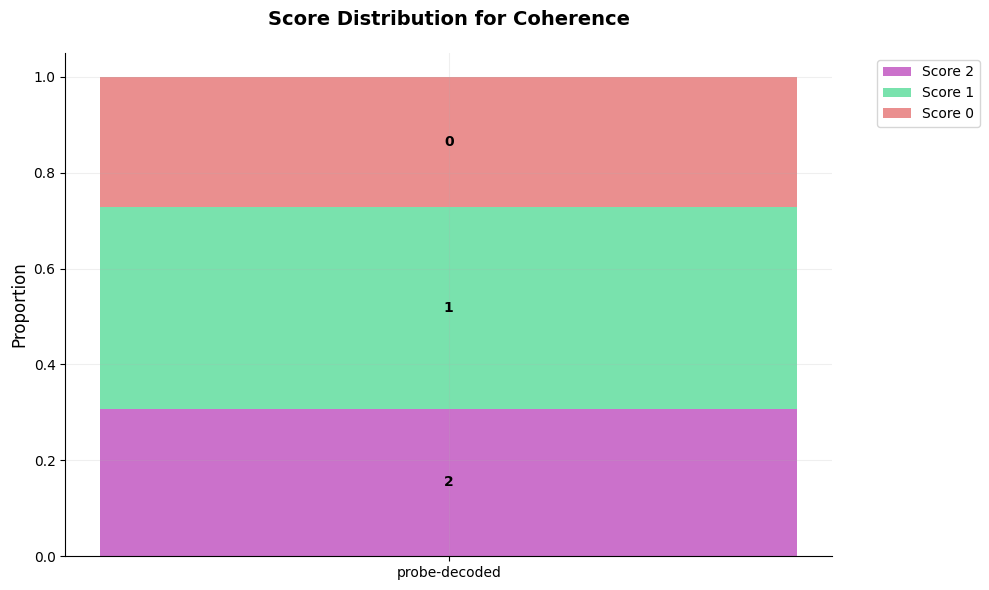


Coherence Score Distribution Table
-----------------------------------------------------------------
Model      | Score -1 | Score 0  | Score 1  | Score 2  | Score 3  |
-----------------------------------------------------------------
probe-decoded |   27.10% |   42.10% |   30.80% |      N/A |      N/A |
-----------------------------------------------------------------

Example pairs for each score:

Score 0:
Reference: Summary: 1.Sugar maple leaves - valuable characteristics and wood - resource and environmentally fri...
Comparison: Summary: 1. Design of Sugarcane Branch - 2. Livestock from Apple - 3. Reliable History - 4. Mixed Us...
---
Reference: Summary: - Types of file systems - NFS, NTFS, ext3 - Effect impact - System speed, reliability - Exa...
Comparison: Description: 1.System features: File type - adjustable storage and functions - Part 2 - System featu...
---

Score 1:
Reference: Description: 1. History of the United Christ Church - Founded in 1951 - Combination of two deno

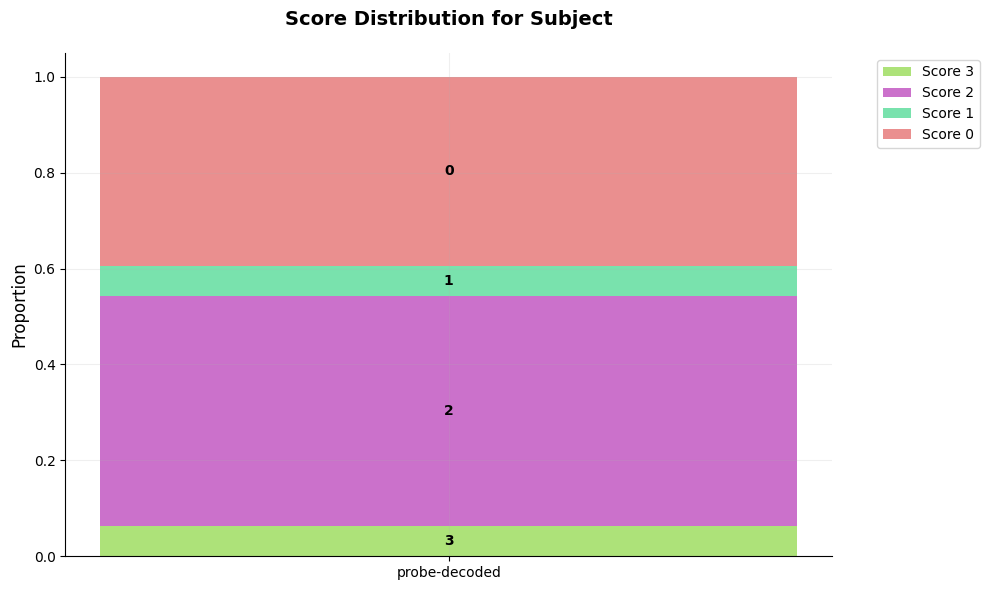


Subject Score Distribution Table
-----------------------------------------------------------------
Model      | Score -1 | Score 0  | Score 1  | Score 2  | Score 3  |
-----------------------------------------------------------------
probe-decoded |   39.40% |    6.30% |   47.90% |    6.40% |      N/A |
-----------------------------------------------------------------

Example pairs for each score:

Score 0:
Reference: Summary: 1.Sugar maple leaves - valuable characteristics and wood - resource and environmentally fri...
Comparison: Summary: 1. Design of Sugarcane Branch - 2. Livestock from Apple - 3. Reliable History - 4. Mixed Us...
---
Reference: Summary: 1.Epsilon-Delta Definition - Discontinuity condition 2.Demonstrating the limit and choose E...
Comparison: Summary: 1. Explanation of deferential consonance - Fixed consonance - Explain deferential function ...
---

Score 1:
Reference: Description: 1. History of the United Christ Church - Founded in 1951 - Combination of two denomi

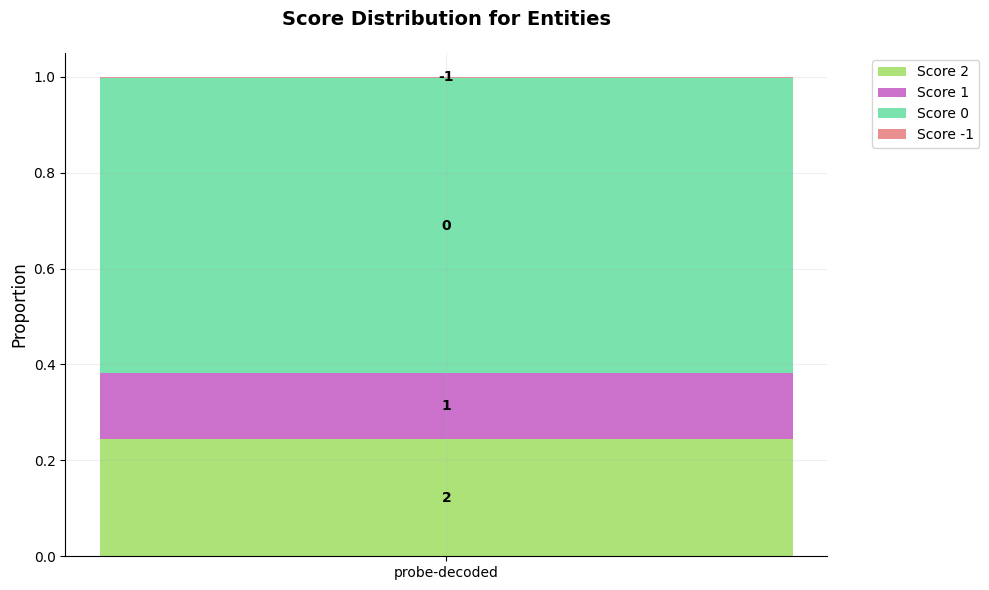


Entities Score Distribution Table
-----------------------------------------------------------------
Model      | Score -1 | Score 0  | Score 1  | Score 2  | Score 3  |
-----------------------------------------------------------------
probe-decoded |    0.30% |   61.50% |   13.80% |   24.40% |      N/A |
-----------------------------------------------------------------

Example pairs for each score:

Score -1:
Reference: Summary: Comet ISON - Close approach to the Sun - Comet 2. Expected disappearance - Scientific under...
Comparison: Summary: 1. Comet Isobel's Watch - Comet Comet's Watch - Comet Comet's Watch - Comet Comet Comet Com...
---
Reference: Summary: Introduction to Raspberry Pi 1 - Enhancement of home brewing - Process control - Raspberry ...
Comparison: Summary: 1. The advantages of using a Ribose oven and a microwave oven 2. The advantages of using a ...
---

Score 0:
Reference: Summary: 1.Sugar maple leaves - valuable characteristics and wood - resource and environmentall

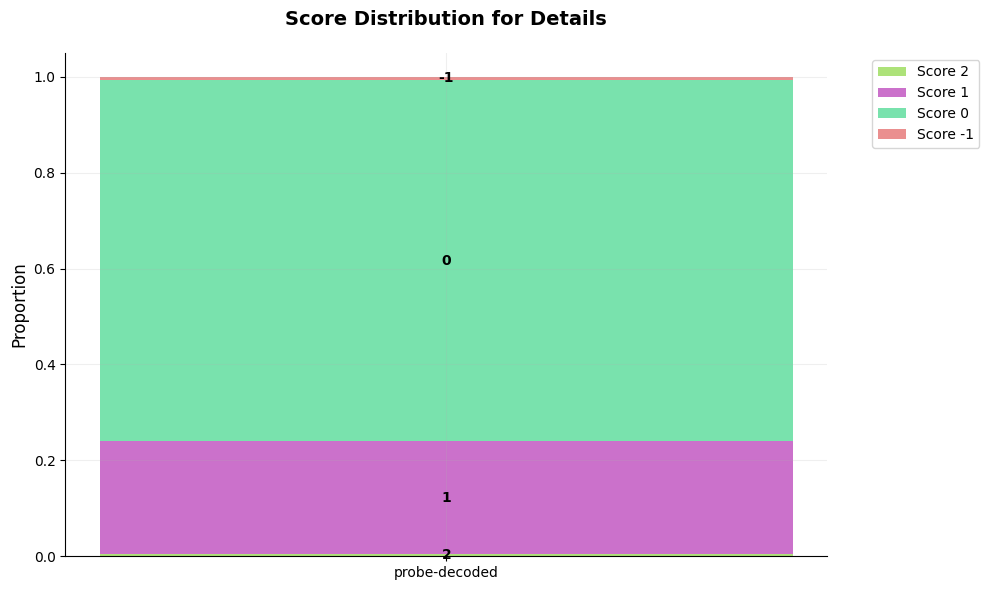


Details Score Distribution Table
-----------------------------------------------------------------
Model      | Score -1 | Score 0  | Score 1  | Score 2  | Score 3  |
-----------------------------------------------------------------
probe-decoded |    0.70% |   75.30% |   23.50% |    0.50% |      N/A |
-----------------------------------------------------------------

Example pairs for each score:

Score -1:
Reference: Summary: Comet ISON - Close approach to the Sun - Comet 2. Expected disappearance - Scientific under...
Comparison: Summary: 1. Comet Isobel's Watch - Comet Comet's Watch - Comet Comet's Watch - Comet Comet Comet Com...
---
Reference: Summary: Introduction to Raspberry Pi 1 - Enhancement of home brewing - Process control - Raspberry ...
Comparison: Summary: 1. The advantages of using a Ribose oven and a microwave oven 2. The advantages of using a ...
---

Score 0:
Reference: Summary: 1.Sugar maple leaves - valuable characteristics and wood - resource and environmentally

In [37]:
# Import plotting functions from plot_rubric.py
import sys
sys.path.append("/workspace/ALGOVERSE/yas/yulia/parascopes/src")
from plot_rubric import calculate_score_proportions, process_scores
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Convert df_scored into the format expected by plot_rubric.py
data_dict = {}
for idx, row in df_scored.iterrows():
    data_dict[str(idx)] = {
        "reference": row["decoded_original"],
        "comparison": row["decoded_predicted"],
        "result": row["rubric_json"]
    }

# Create data dictionary in the expected format
data_dicts = {"probe-decoded": data_dict}

# Create a nice color palette function
def get_color(i, total):
    hue = i * 150 % 360
    # Convert HSL to RGB (approximation)
    r = 0.6 + 0.3 * np.cos(np.radians(hue))
    g = 0.6 + 0.3 * np.cos(np.radians(hue - 120))
    b = 0.6 + 0.3 * np.cos(np.radians(hue + 120))
    return (r, g, b)

# Plot visualizations for key metrics
metrics = ["coherence", "subject", "entities", "details"]
for metric in metrics:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for label, data_dict in data_dicts.items():
        data_list = list(data_dict.values())
        scores = process_scores(data_list, metric)
        proportions = calculate_score_proportions(scores)
        unique_scores = sorted(set(scores))
        
        bottom = 0
        for i, prop in reversed(list(enumerate(proportions))):
            color = get_color(i, len(proportions))
            bar = ax.bar([label], [prop], bottom=bottom, color=color,
                        label=f'Score {unique_scores[i]}', alpha=0.8)
            # Add score text in the middle of each bar
            ax.text(0, bottom + prop/2, str(unique_scores[i]), 
                   ha='center', va='center', color='black',
                   fontweight='bold', fontsize=10)
            bottom += prop
    
    ax.set_title(f'Score Distribution for {metric.capitalize()}', pad=20, fontsize=14, fontweight='bold')
    ax.set_ylabel('Proportion', fontsize=12)
    ax.grid(True, alpha=0.2)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Set background color to white
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')
    
    plt.tight_layout()
    plt.show()
    
    # Print score distribution table
    print(f"\n{metric.capitalize()} Score Distribution Table")
    print("-" * 65)
    print("Model      | Score -1 | Score 0  | Score 1  | Score 2  | Score 3  |")
    print("-" * 65)
    
    for label in ["probe-decoded"]:
        proportions = calculate_score_proportions(process_scores(list(data_dict.values()), metric))
        row = f"{label:<10} |"
        for i in range(5):
            if i < len(proportions):
                row += f" {proportions[i]:8.2%} |"
            else:
                row += f" {'N/A':>8} |"
        print(row)
    print("-" * 65)
    
    # Print some example pairs for each score
    print("\nExample pairs for each score:")
    for score in unique_scores:
        examples = [item for item in data_dict.values() 
                   if json.loads(item["result"])["scoring"][metric] == score][:2]
        if examples:
            print(f"\nScore {score}:")
            for ex in examples:
                print(f"Reference: {ex['reference'][:100]}...")
                print(f"Comparison: {ex['comparison'][:100]}...")
                print("---")


In [41]:
# Calculate detailed statistics
def print_rubric_statistics(df, title):
    print("=" * 80)
    print(f"DETAILED RUBRIC STATISTICS - llama 70B outline VS llama-3b decoded")
    print("=" * 80)
    
    # Sample size
    print(f"\nSample Size: {len(df)} outline pairs")
    
    # Total score statistics
    print("\nTotal Score Statistics (sum of all rubric categories):")
    print(f"Average Total Score: {df['score_sum'].mean():.2f}")
    print(f"Max Total Score: {df['score_sum'].max():.2f}")
    print(f"Min Total Score: {df['score_sum'].min():.2f}")
    print(f"Standard Deviation: {df['score_sum'].std():.2f}")
    
    # Maximum possible scores for each category
    max_scores = {
        'score_complexity': 3,
        'score_coherence': 3,
        'score_hierarchy': 3,
        'score_coverage': 3,
        'score_ordering': 3,
        'score_subject': 4,
        'score_entities': 4,
        'score_details': 3,
        'score_conciseness': 2,
        'score_identical': 1
    }
    
    # Get score columns excluding sum and mean
    score_cols = [col for col in df.columns if col.startswith('score_') 
                  and col not in ['score_sum', 'score_mean']]
    
    # Individual rubric categories
    print("\nRubric Category Statistics:")
    print("-" * 60)
    print(f"{'Category':<20} {'Average':<10} {'Max':<10} {'% of Max':<10}")
    print("-" * 60)
    
    category_stats = []
    for col in score_cols:
        avg_score = df[col].mean()
        max_score = df[col].max()
        max_possible = max_scores[col]
        percent_of_max = (avg_score / max_possible) * 100
        
        category_stats.append({
            'category': col.replace('score_', ''),
            'average': avg_score,
            'max': max_score,
            'percent_of_max': percent_of_max
        })
        
        print(f"{col.replace('score_', ''):<20} {avg_score:>8.2f}  {max_score:>8.2f}  {percent_of_max:>8.1f}%")
    
    # Top performing categories
    print("\nTop 3 Best Performing Categories (by % of max possible score):")
    print("-" * 60)
    sorted_stats = sorted(category_stats, key=lambda x: x['percent_of_max'], reverse=True)
    for i, stat in enumerate(sorted_stats[:3], 1):
        print(f"{i}. {stat['category']:<20} ({stat['percent_of_max']:.1f}% of max possible score)")
    
    # Categories with highest absolute scores
    print("\nTop 3 Categories by Absolute Score:")
    print("-" * 60)
    sorted_by_score = sorted(category_stats, key=lambda x: x['average'], reverse=True)
    for i, stat in enumerate(sorted_by_score[:3], 1):
        print(f"{i}. {stat['category']:<20} (avg score: {stat['average']:.2f})")
    
    # Distribution of total scores
    print("\nDistribution of Total Scores:")
    print("-" * 60)
    percentiles = [0, 25, 50, 75, 100]
    for p in percentiles:
        score = np.percentile(df['score_sum'], p)
        print(f"{p}th percentile: {score:.2f}")

# Run statistics for the test notebook
print_rubric_statistics(df_scored, "Probe Decoded Comparison")


DETAILED RUBRIC STATISTICS - llama 70B outline VS llama-3b decoded

Sample Size: 1000 outline pairs

Total Score Statistics (sum of all rubric categories):
Average Total Score: 5.85
Max Total Score: 17.00
Min Total Score: -2.00
Standard Deviation: 4.63

Rubric Category Statistics:
------------------------------------------------------------
Category             Average    Max        % of Max  
------------------------------------------------------------
complexity               0.97      3.00      32.4%
coherence                1.04      2.00      34.6%
hierarchy                0.78      2.00      26.0%
coverage                 0.40      2.00      13.3%
ordering                 0.02      2.00       0.7%
subject                  1.21      3.00      30.3%
entities                 0.62      2.00      15.6%
details                  0.24      2.00       7.9%
conciseness              0.57      2.00      28.3%
identical                0.00      0.00       0.0%

Top 3 Best Performing Categorie

/tmp/ipykernel_764556/1536327662.py:31: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




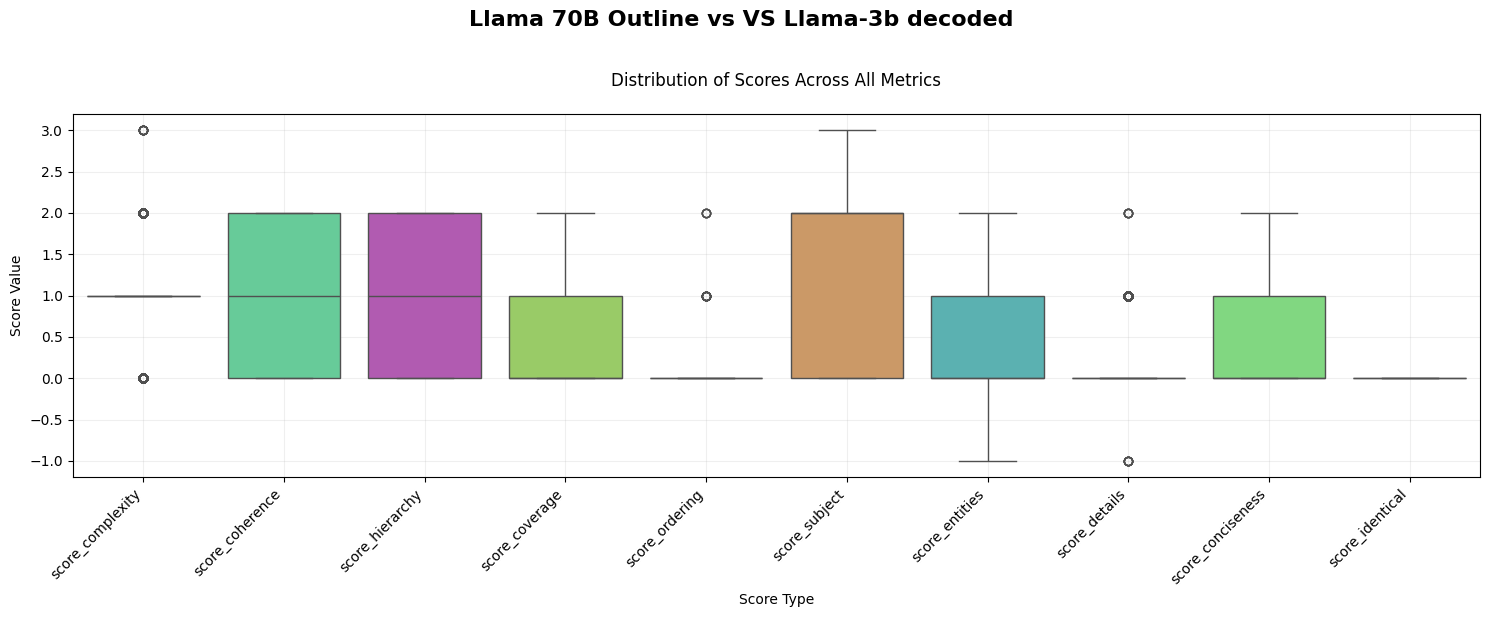

/tmp/ipykernel_764556/1536327662.py:43: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




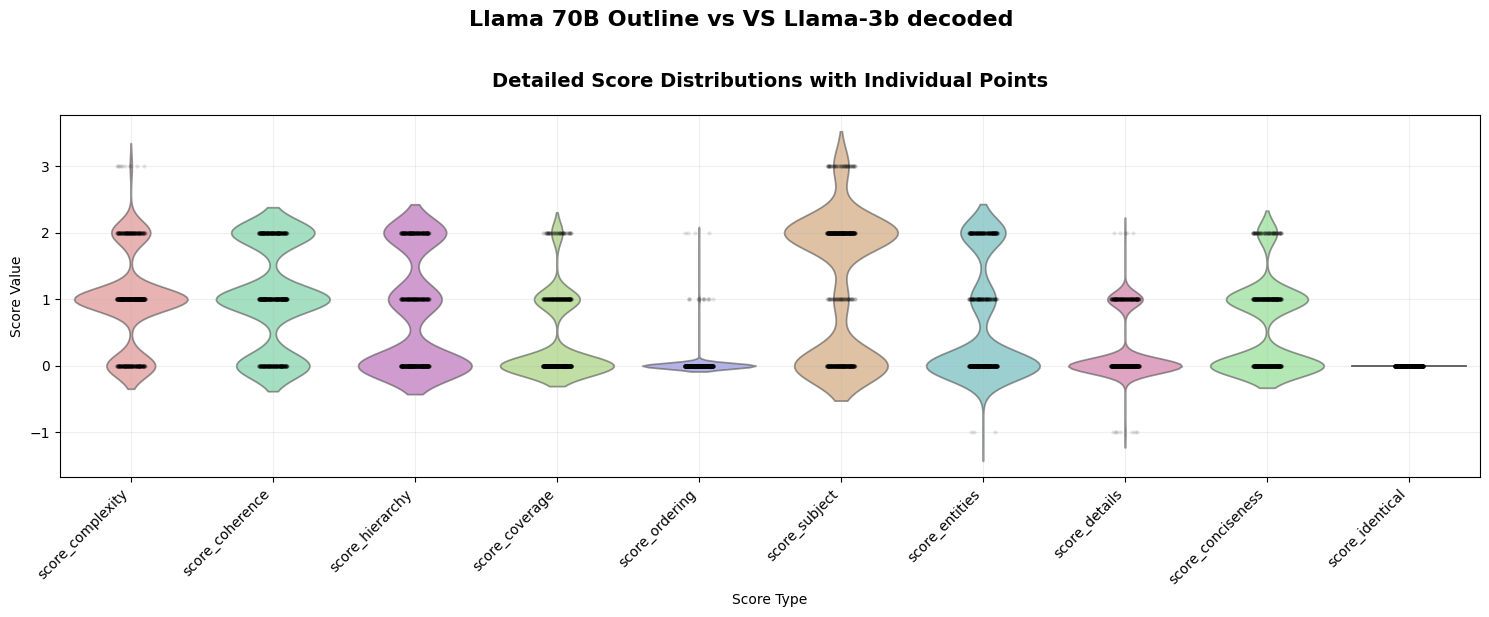


Summary Statistics for Each Score:
       score_complexity  score_coherence  score_hierarchy  score_coverage  score_ordering  score_subject  score_entities  score_details  score_conciseness  score_identical  score_sum  score_mean
count          1000.000         1000.000         1000.000        1000.000        1000.000       1000.000        1000.000       1000.000           1000.000           1000.0   1000.000    1000.000
mean              0.972            1.037            0.779           0.398           0.022          1.213           0.623          0.238              0.566              0.0      5.848       0.585
std               0.687            0.760            0.848           0.608           0.172          1.041           0.854          0.453              0.657              0.0      4.632       0.463
min               0.000            0.000            0.000           0.000           0.000          0.000          -1.000         -1.000              0.000              0.0     -2.000  

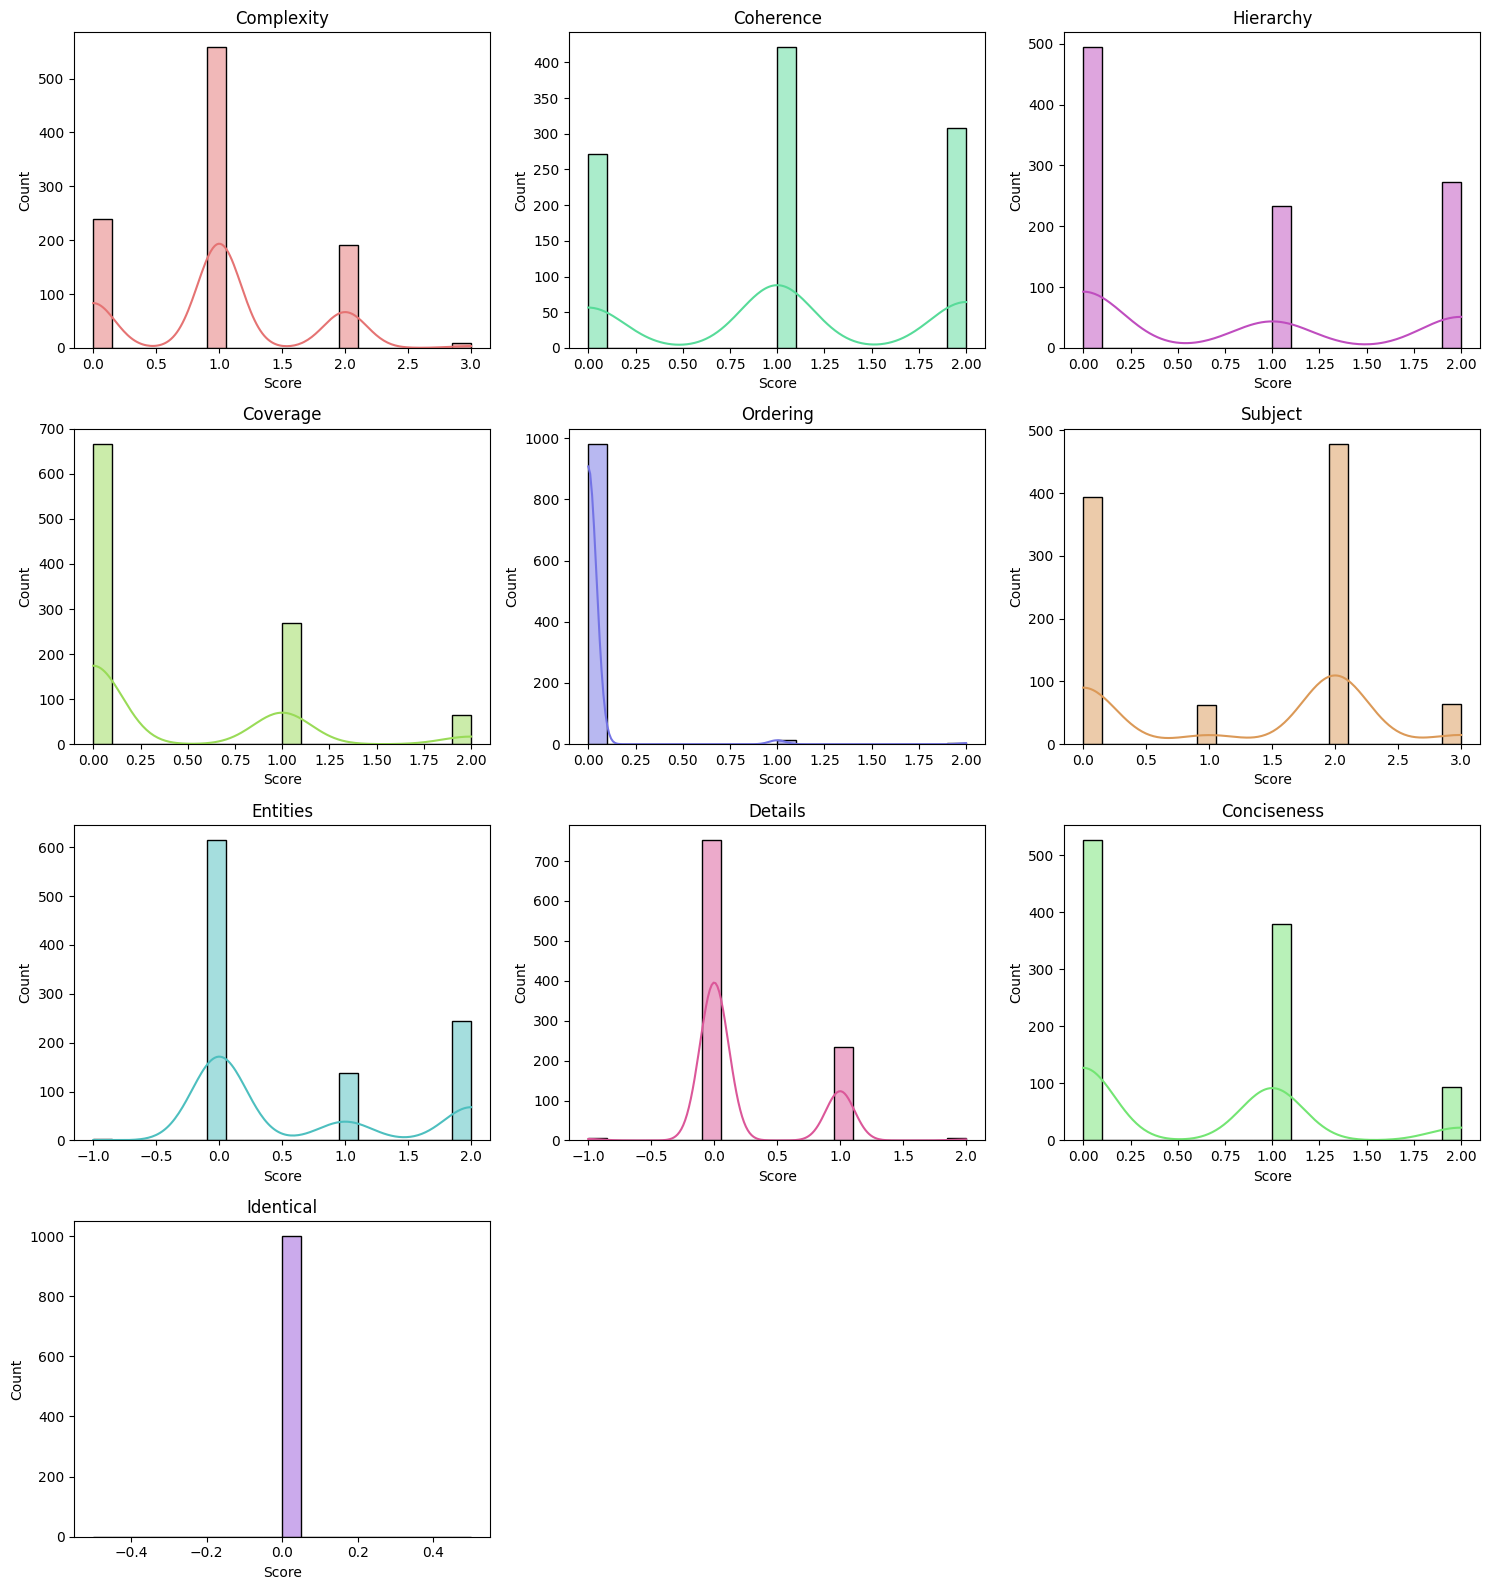

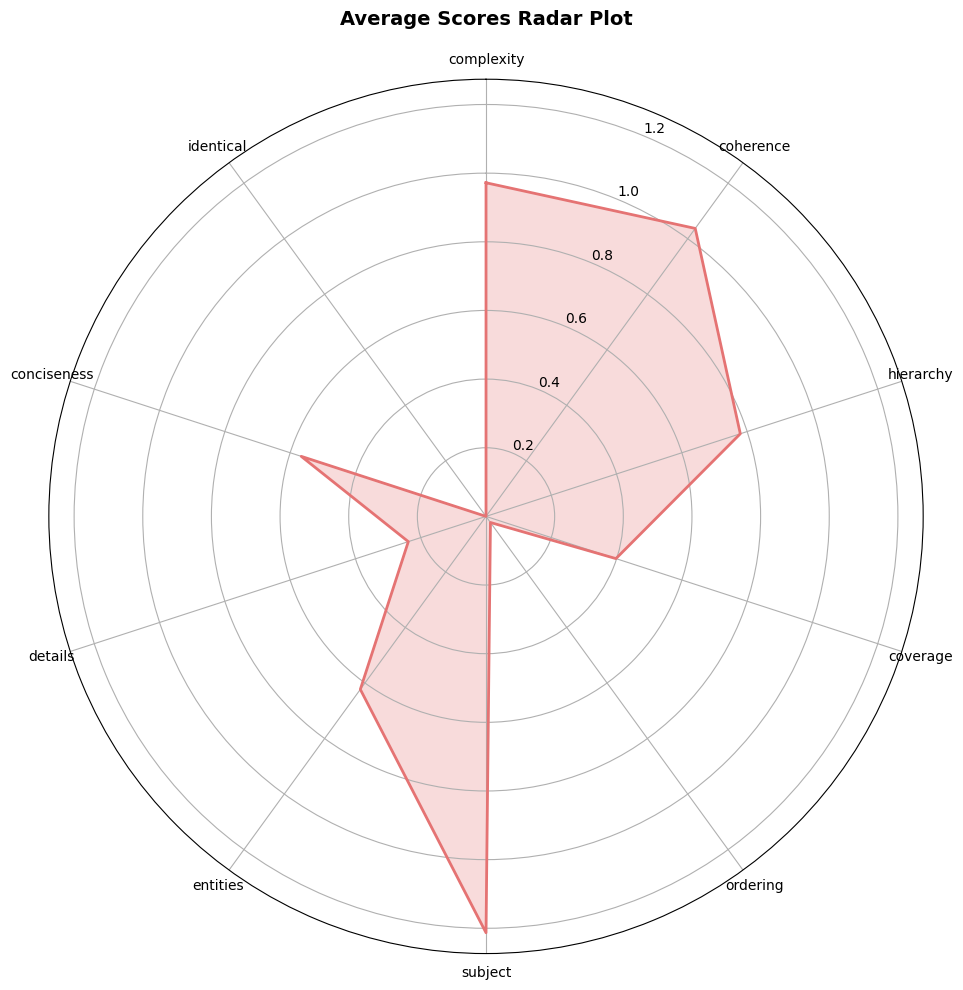


Interesting Statistics:
Highest scoring metric: score_subject (avg: 1.21)
Lowest scoring metric: score_identical (avg: 0.00)

Metrics with highest variance:
score_subject       1.084716
score_entities      0.729601
score_hierarchy     0.718878
score_coherence     0.578209
score_complexity    0.471688


In [44]:
# Additional visualizations for the scores
import seaborn as sns

# Create custom color palette function
def get_color(i, total=1):
    hue = i * 150 % 360
    r = 0.6 + 0.3 * np.cos(np.radians(hue))
    g = 0.6 + 0.3 * np.cos(np.radians(hue - 120))
    b = 0.6 + 0.3 * np.cos(np.radians(hue + 120))
    return (r, g, b)

# Create color palette for all metrics
score_cols = [col for col in df_scored.columns if col.startswith('score_')]
score_metrics = [col for col in score_cols if col not in ['score_sum', 'score_mean']]
palette = {metric: get_color(i, len(score_metrics)) for i, metric in enumerate(score_metrics)}

# # 1. Correlation heatmap between all scores
# plt.figure(figsize=(12, 10))
# mask = np.triu(np.ones_like(df_scored[score_cols].corr(), dtype=bool))
# sns.heatmap(df_scored[score_cols].corr(), annot=True, cmap='RdYlBu_r', center=0, fmt='.2f',
#             mask=mask, square=True)
# plt.title('Correlation between Different Scores', pad=20, fontsize=14, fontweight='bold')
# plt.xticks(rotation=45, ha='right')
# plt.yticks(rotation=0)
# plt.tight_layout()
# plt.show()

# 2. Box plots for all individual scores
plt.figure(figsize=(15, 6))
score_data = df_scored[score_metrics].melt()
sns.boxplot(x='variable', y='value', data=score_data, palette=palette)
plt.xticks(rotation=45, ha='right')
plt.suptitle('Llama 70B Outline vs VS Llama-3b decoded ', y=1.02, fontsize=16, fontweight='bold')
plt.title('Distribution of Scores Across All Metrics', pad=20, fontsize=12)
plt.xlabel('Score Type')
plt.ylabel('Score Value')
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

# 3. Violin plots with individual points
plt.figure(figsize=(15, 6))
sns.violinplot(x='variable', y='value', data=score_data, palette=palette, inner=None, alpha=0.6)
sns.stripplot(x='variable', y='value', data=score_data, color='black', alpha=0.1, size=3)
plt.xticks(rotation=45, ha='right')
plt.suptitle('Llama 70B Outline vs VS Llama-3b decoded ', y=1.02, fontsize=16, fontweight='bold')

plt.title('Detailed Score Distributions with Individual Points', pad=20, fontsize=14, fontweight='bold')
plt.xlabel('Score Type')
plt.ylabel('Score Value')
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

# 4. Summary statistics
print("\nSummary Statistics for Each Score:")
print(df_scored[score_cols].describe().round(3).to_string())

# 5. Histogram grid for all scores
n_cols = 3
n_rows = (len(score_metrics) + n_cols - 1) // n_cols

plt.figure(figsize=(15, 4*n_rows))
for i, metric in enumerate(score_metrics, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(df_scored[metric], bins=20, kde=True, color=palette[metric])
    plt.title(metric.replace('score_', '').title())
    plt.xlabel('Score')
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

# 6. Radar plot of average scores
# Prepare data for radar plot
metrics = [col.replace('score_', '') for col in score_metrics]
values = df_scored[score_metrics].mean()

# Number of variables
num_vars = len(metrics)

# Compute angle for each axis
angles = [n / float(num_vars) * 2 * np.pi for n in range(num_vars)]
angles += angles[:1]

# Initialize the spider plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

# Plot data
values = values.tolist()
values += values[:1]

# Get a nice color for the radar plot
radar_color = get_color(0)
ax.plot(angles, values, color=radar_color, linewidth=2)
ax.fill(angles, values, color=radar_color, alpha=0.25)

# Fix axis to go in the right order and start at 12 o'clock
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Draw axis lines for each angle and label
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics, fontsize=10)

# Add title
plt.title('Average Scores Radar Plot', pad=20, fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print interesting findings
print("\nInteresting Statistics:")
print(f"Highest scoring metric: {score_metrics[values[:-1].index(max(values[:-1]))]} (avg: {max(values[:-1]):.2f})")
print(f"Lowest scoring metric: {score_metrics[values[:-1].index(min(values[:-1]))]} (avg: {min(values[:-1]):.2f})")
print("\nMetrics with highest variance:")
variances = df_scored[score_metrics].var().sort_values(ascending=False)
print(variances.head().to_string())
